In [37]:
import re
import random
import pandas as pd
import hashlib

In [38]:
with open('certcards2.txt', mode='r', encoding='utf8') as f:
    all_cards = f.read()
    
card_split_pattern = r'\n\n\n\d+\n'
all_cards = re.split(card_split_pattern, all_cards)
# Use re.DOTALL to allow . to match newline characters
card_pattern = re.compile(r'(.+?)\n([\s\S]+)', re.DOTALL)
cards = [(match.group(1), match.group(2)) for cstring in all_cards if (match := re.search(card_pattern, cstring))]

# removing the cards that have no content and trimming
cards = [(subject, stripped_content) for subject, content in cards if len(stripped_content := content.strip()) > 5]

def hash_string_md5(s):
    """
    Hashes a string using MD5 and returns a truncated hash for efficiency.

    Parameters:
    - s (str): The input string to hash.

    Returns:
    - str: The truncated hexadecimal hash string.
    """
    if pd.isnull(s):
        return None  # Handle NaN values gracefully
    return hashlib.md5(s.encode('utf-8')).hexdigest()  # Truncate to first 12 characters


def remake_card_document(existing_cards: pd.DataFrame, filename: str='certcards2.txt'):
    with open(filename, mode='w', encoding='utf8') as f:
        i = 1
        for _, row in existing_cards.iterrows():
            f.write('\n'*6)
            f.write(str(i)+'\n')  
            f.write(row['head']+'\n')
            f.write(row['body'])
            i+=1
    print(F"Cards found: {existing_cards.shape[0]}")


existing_cards = pd.DataFrame(cards, columns=['head', 'body'])


# existing_cards['age'] = [random.random() for _ in existing_cards.index]
existing_cards['hash'] = existing_cards['body'].apply(hash_string_md5)
existing_cards

card_ages = pd.read_json('card_ages.json')
card_ages = card_ages.drop_duplicates(subset=['hash'], keep='first')

cards_to_age = pd.merge(
    left=existing_cards,
    right=card_ages[['hash', 'age']],
    left_on='hash', right_on='hash',
    how='left'
)

cards_to_age['head'] = cards_to_age['head'].str.strip()

if cards_to_age['age'].sum() > 2e4: age_factor = 1
else: age_factor = 1.00

cards_to_age['age'] = cards_to_age['age'].fillna(0)
cards_to_age['age'] = cards_to_age['age'] * age_factor
cards_to_age['age'] = cards_to_age['age'] + [random.expovariate(.75) for _ in cards_to_age.index]
# cards_to_age['age'] = cards_to_age['age'] * [random.expovariate(.75) for _ in cards_to_age.index]


cards_to_age = cards_to_age.drop_duplicates(subset=['hash'], keep='first')

cards_to_age['subject_mean_age'] = cards_to_age.groupby('head')['age'].transform('mean')
cards_to_age['subject_highest_age'] = cards_to_age.groupby('head')['age'].transform('max')
cards_to_age['subject_age_sum'] = cards_to_age.groupby('head')['age'].transform('sum')
cards_to_age['head_random_roll'] = cards_to_age.groupby('head')['head'].transform(lambda x: random.random())


cards_to_age.sort_values('age')[['age', 'head', 'hash']].to_json('card_ages.json', indent=2)

existing_cards = cards_to_age

In [39]:
stats = existing_cards.groupby('head').agg({'age': ['sum', 'mean'], 'head': 'count'}).sort_values(('age', 'sum'))
stats.columns = stats.columns.to_flat_index()
stats.columns = ['_'.join(col).strip() for col in stats.columns]
stats.index.name = None
stats

,age_sum,age_mean,head_count
Python,0.663372,0.663372,1
SharePoint,541.365180,31.845011,17
Azure AI Search,661.977290,47.284092,14
Azure Functions + PP365,780.335030,16.602873,47
Lost in a Good Book,993.148534,49.657427,20
Taxes,1144.016453,114.401645,10
Network Mapping,1321.498979,62.928523,21
PP365,1620.842413,162.084241,10
Finance Junk,1758.230296,219.778787,8
Diffusers Library,2033.044073,203.304407,10


# Histogram

56518.23


<Axes: >

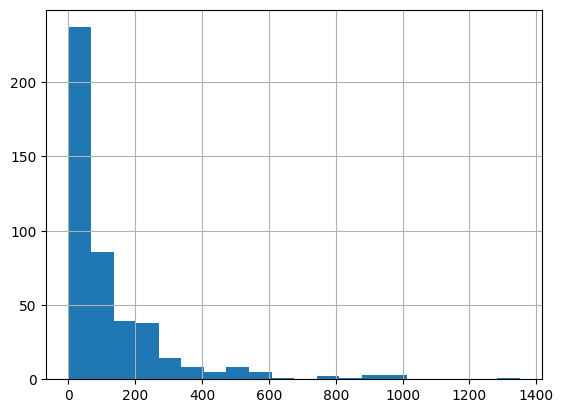

In [40]:
print(f"{existing_cards['age'].sum(0):.2f}")
existing_cards['age'].hist(bins=20)

# Completely Random Shuffle

In [41]:
# existing_cards = existing_cards.sample(frac=1)
# remake_card_document(filename='certcards2.txt', existing_cards = existing_cards)

# Age Sort

In [42]:
existing_cards = existing_cards.sort_values('age', ascending=False)
remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)
existing_cards.head(10)

Cards found: 451


,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll
100,Search Engine Optimization,SEOquake is a browser extension that provides ...,d7914640266665f7eb3726d2cace41c7,1349.771184,188.047417,1349.771184,3196.806085,0.444642
341,PEP 8,Avoid Using Backslashes for Line Continuation:...,76f976ebf1cbf875e2b01e2d6d2978ad,968.767642,115.657901,968.767642,3354.079129,0.282489
53,Azure AI Foundry,Each hub you create has a default storage acco...,0d136c510811d581f245965f2ad809ee,956.048260,232.446628,956.048260,3486.699414,0.028619
170,Home Network Project,Front: How can you whitelist a domain in Pi-ho...,a58daca7fa9168da6a36391f0005fe36,955.291467,262.429952,955.291467,5248.599039,0.223373
68,Azure Functions,Durable Functions allows you to define statefu...,3240de336fc685d6d8fddd8ac482fabd,934.383768,187.861773,934.383768,3005.788364,0.582925
172,Home Network Project,Front: What is Fail2Ban and how does it protec...,d7fc83e3380f6d95ec44141a17d86066,920.025002,262.429952,955.291467,5248.599039,0.223373
171,Home Network Project,Front: What is Rate Limiting and how does it h...,8178df4fba6be87bebbac33e10e32135,916.343790,262.429952,955.291467,5248.599039,0.223373
294,Open Source/GitHub,Semantic Versioning\n\nA versioning scheme tha...,9aef26d41b1623fdd93eaeef436024ea,867.404253,98.568438,867.404253,2267.074065,0.528449
117,Email Auth and Security,DKIM (DomainKeys Identified Mail)\n\nAn email ...,991e90ea49a5db4146ebabcbdc7fe747,800.679800,193.244932,800.679800,3285.163846,0.053300
230,Powershell,Start-Service\nStarts a Windows service by nam...,678b4e19869c1a72f5aa179b6733ec92,780.889563,178.413524,780.889563,3746.683997,0.384028


# Headers with fewest notes first

In [43]:
# frequency = existing_cards['head'].value_counts(ascending=True)

# existing_cards = pd.merge(
#     left=existing_cards,
#     right=frequency.rename('frequency'),
#     left_on='head', right_index=True,
#     how='left'
# )
# existing_cards['oldest'] = existing_cards.groupby('head')['age'].transform('max')
# existing_cards['subject_highest_age'] = existing_cards['subject_highest_age'] * -1
# existing_cards['age'] = existing_cards['age'] * -1


# existing_cards.sort_values(['frequency', 'subject_highest_age', 'age'], ascending=True, inplace=True)

# remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)

# existing_cards.head(10)

# Focus on one header

In [44]:
# heads = existing_cards['head'].value_counts()
# heads = heads[heads > 5].index.tolist()
# one_header = random.sample(heads, 1)[0]
# existing_cards['pick_head'] = existing_cards['head'].apply(
#     lambda h: 0 if h == one_header else 1 
# )

# remake_card_document(existing_cards=existing_cards.sort_values('pick_head'))

## Header with oldest cards first

In [45]:
# existing_cards['oldest'] = existing_cards.groupby('head')['age'].transform('max')
# existing_cards.sort_values(['oldest', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

## Headers with greatest mean card age first

In [46]:
# existing_cards.sort_values(['subject_mean_age', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

## Headers with greatest age sum first

In [47]:
# existing_cards.sort_values(['subject_age_sum', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

# N-fold shuffle

## Random

In [48]:
# n = 3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n
# existing_cards['age'] *= -1
# existing_cards.sort_values(['n_fold', 'head_random_roll', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)

## Age Sum

In [49]:
# n=4
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n

# existing_cards['subject_age_sum'] = existing_cards['subject_age_sum'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_age_sum', 'age'], inplace=True)
# existing_cards.head(10)

# remake_card_document(existing_cards=existing_cards)

## Age max

In [50]:
# n = 6
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] // n

# existing_cards['subject_highest_age'] = existing_cards['subject_highest_age'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_highest_age', 'age'], inplace=True)

# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)


## Age Mean

In [51]:
# n=3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] // n

# existing_cards['subject_mean_age'] = existing_cards['subject_mean_age'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_mean_age', 'age'], inplace=True)
# existing_cards.head(10)

# remake_card_document(existing_cards=existing_cards)


In [52]:
existing_cards.head(10)

,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll
100,Search Engine Optimization,SEOquake is a browser extension that provides ...,d7914640266665f7eb3726d2cace41c7,1349.771184,188.047417,1349.771184,3196.806085,0.444642
341,PEP 8,Avoid Using Backslashes for Line Continuation:...,76f976ebf1cbf875e2b01e2d6d2978ad,968.767642,115.657901,968.767642,3354.079129,0.282489
53,Azure AI Foundry,Each hub you create has a default storage acco...,0d136c510811d581f245965f2ad809ee,956.048260,232.446628,956.048260,3486.699414,0.028619
170,Home Network Project,Front: How can you whitelist a domain in Pi-ho...,a58daca7fa9168da6a36391f0005fe36,955.291467,262.429952,955.291467,5248.599039,0.223373
68,Azure Functions,Durable Functions allows you to define statefu...,3240de336fc685d6d8fddd8ac482fabd,934.383768,187.861773,934.383768,3005.788364,0.582925
172,Home Network Project,Front: What is Fail2Ban and how does it protec...,d7fc83e3380f6d95ec44141a17d86066,920.025002,262.429952,955.291467,5248.599039,0.223373
171,Home Network Project,Front: What is Rate Limiting and how does it h...,8178df4fba6be87bebbac33e10e32135,916.343790,262.429952,955.291467,5248.599039,0.223373
294,Open Source/GitHub,Semantic Versioning\n\nA versioning scheme tha...,9aef26d41b1623fdd93eaeef436024ea,867.404253,98.568438,867.404253,2267.074065,0.528449
117,Email Auth and Security,DKIM (DomainKeys Identified Mail)\n\nAn email ...,991e90ea49a5db4146ebabcbdc7fe747,800.679800,193.244932,800.679800,3285.163846,0.053300
230,Powershell,Start-Service\nStarts a Windows service by nam...,678b4e19869c1a72f5aa179b6733ec92,780.889563,178.413524,780.889563,3746.683997,0.384028


In [53]:
existing_cards.head(10)['age'].sum()

9449.604729476716